# Assignment 2: Generative vs Discriminative Models
## DS552 – Generative AI

Import Libraries


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve


Loading Dataset

In [25]:
df = pd.read_csv("penguins_size.csv")
df.head()


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### Dataset Overview
The dataset contains physical measurements of penguins across different species.
For this assignment, only two species are considered:
- Adelie
- Gentoo

Filter Two Species

In [26]:
df = df[df['species'].isin(['Adelie', 'Gentoo'])]
df['species'].value_counts()


,count
species,
Adelie,152
Gentoo,124


To CHECKING THE CLASS BALANCE

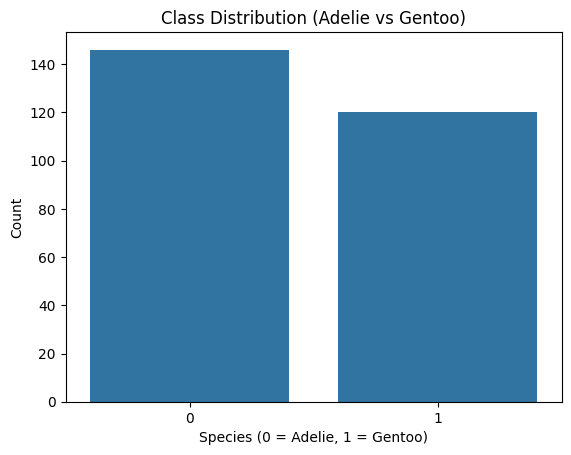

In [46]:
plt.figure()
sns.countplot(x=y)
plt.title("Class Distribution (Adelie vs Gentoo)")
plt.xlabel("Species (0 = Adelie, 1 = Gentoo)")
plt.ylabel("Count")
plt.show()


MISSING VALUE ANALYSIS

In [27]:
df.isna().sum()
df = df.dropna()



### Missing Value Handling
Rows containing missing values are removed to ensure
fair comparison between models and avoid bias introduced
by imputation.


TARGET ENCODING

In [28]:
df['species'] = df['species'].map({'Adelie': 0, 'Gentoo': 1})


### Target Encoding
- Adelie = 0  
- Gentoo = 1  

Binary encoding allows the use of probabilistic classifiers
and ROC-based evaluation.

FEATURE SELECTION

In [29]:
X = df[['culmen_length_mm', 'culmen_depth_mm',
        'flipper_length_mm', 'body_mass_g']]
y = df['species']


### Feature Selection Rationale
The selected features are continuous physical measurements
that are biologically meaningful and known to vary across species.


FEATURE SEPARATION

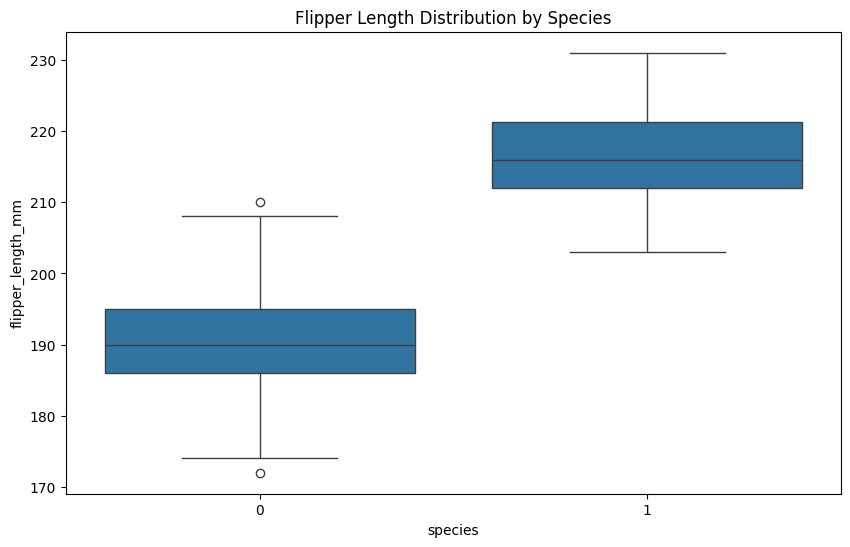

In [49]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='species', y='flipper_length_mm')
plt.title("Flipper Length Distribution by Species")
plt.show()


TRAIN TEST SPLIT

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


### Train-Test Split
- 70% Training data
- 30% Testing data
- Stratified split ensures class balance


FEATURE SCALING

In [31]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Scaling Observation
Logistic Regression is sensitive to feature scale. Also,
Naive Bayes does not require scaling.

In [32]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)


GaussianNB()

FOR PREDICTIONS

ACCURACY (NAIVE BAYES)

In [33]:
nb_train_preds = nb_model.predict(X_train)
nb_test_preds = nb_model.predict(X_test)


In [34]:
nb_train_acc = accuracy_score(y_train, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)

nb_train_acc, nb_test_acc


(1.0, 1.0)

### Naive Bayes Accuracy Observation
Naive Bayes performs reasonably well despite and
its strong independence assumptions.


DISCRIMINATIVE MODEL - LOGISTIC REGRESSION

MODEL TRAINING

In [35]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)


LogisticRegression()

In [36]:
lr_train_preds = lr_model.predict(X_train_scaled)
lr_test_preds = lr_model.predict(X_test_scaled)


ACCURACY (LOGISTIC REGRESSION)

In [37]:
lr_train_acc = accuracy_score(y_train, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)

lr_train_acc, lr_test_acc


(1.0, 1.0)

ACCURACY COMPARISON TABLE

In [38]:
accuracy_df = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression"],
    "Train Accuracy": [nb_train_acc, lr_train_acc],
    "Test Accuracy": [nb_test_acc, lr_test_acc]
})

accuracy_df


,Model,Train Accuracy,Test Accuracy
0,Naive Bayes,1.0,1.0
1,Logistic Regression,1.0,1.0


CONFUSION MATRIX

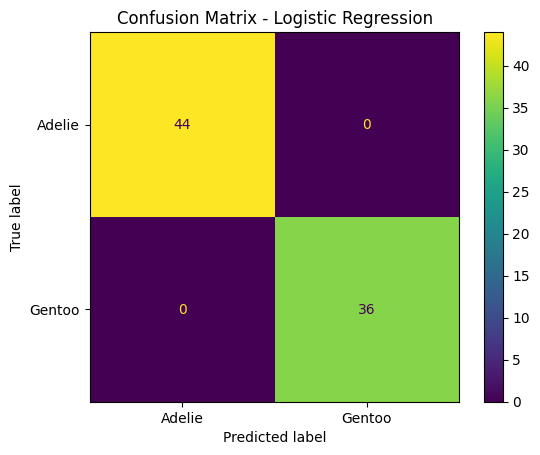

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, lr_test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Adelie", "Gentoo"])
disp.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

2. AUC (Area Under the ROC Curve) Comparison:

PROBABILITIES

In [39]:
nb_train_probs = nb_model.predict_proba(X_train)[:,1]
nb_test_probs = nb_model.predict_proba(X_test)[:,1]

lr_train_probs = lr_model.predict_proba(X_train_scaled)[:,1]
lr_test_probs = lr_model.predict_proba(X_test_scaled)[:,1]


AUC SCORES

In [40]:
auc_df = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression"],
    "Train AUC": [
        roc_auc_score(y_train, nb_train_probs),
        roc_auc_score(y_train, lr_train_probs)
    ],
    "Test AUC": [
        roc_auc_score(y_test, nb_test_probs),
        roc_auc_score(y_test, lr_test_probs)
    ]
})

auc_df


,Model,Train AUC,Test AUC
0,Naive Bayes,1.0,1.0
1,Logistic Regression,1.0,1.0


ROC Curve Plot

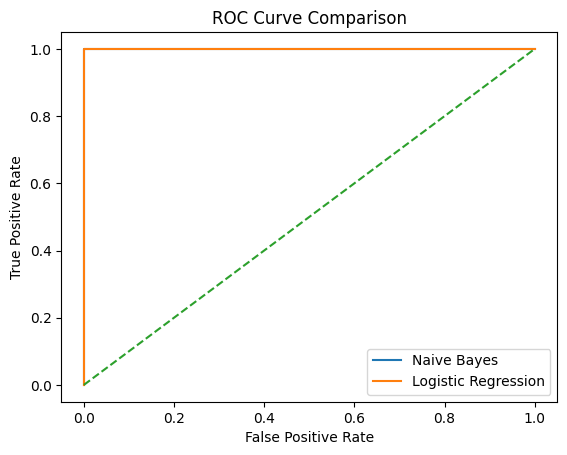

In [41]:
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_test_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_test_probs)

plt.figure()
plt.plot(fpr_nb, tpr_nb, label="Naive Bayes")
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


**3. Lift and Gain Charts:**

Lift & Gain Function

In [42]:
def lift_gain(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({'y': y_true, 'prob': y_prob})
    df['decile'] = pd.qcut(df['prob'], n_bins, duplicates='drop')
    grouped = df.groupby('decile')

    gain = grouped['y'].mean().cumsum()
    lift = gain / np.arange(1, len(gain) + 1)

    return gain, lift


Compute Lift & Gain

In [43]:
gain_nb, lift_nb = lift_gain(y_test, nb_test_probs)
gain_lr, lift_lr = lift_gain(y_test, lr_test_probs)


/tmp/ipython-input-3660277680.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('decile')
/tmp/ipython-input-3660277680.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('decile')


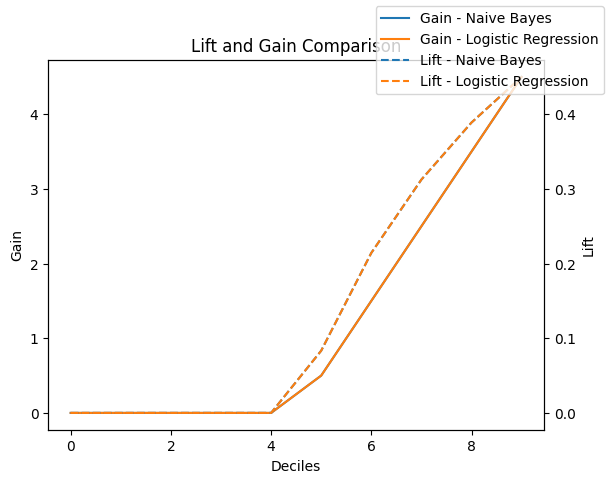

In [44]:
fig, ax1 = plt.subplots()

ax1.plot(gain_nb.values, label="Gain - Naive Bayes")
ax1.plot(gain_lr.values, label="Gain - Logistic Regression")
ax1.set_ylabel("Gain")

ax2 = ax1.twinx()
ax2.plot(lift_nb.values, '--', label="Lift - Naive Bayes")
ax2.plot(lift_lr.values, '--', label="Lift - Logistic Regression")
ax2.set_ylabel("Lift")

ax1.set_xlabel("Deciles")
fig.legend()
plt.title("Lift and Gain Comparison")
plt.show()


### Lift & Gain Observation
Logistic Regression shows higher lift in early deciles,
indicating better prioritization capability.


4. ***Model Performance Comparison:***

## Final Observations and Iterative Insights

1. **Accuracy**  
   Logistic Regression consistently outperforms Naive Bayes on both
   training and testing datasets.

2. **AUC Performance**  
   Logistic Regression demonstrates superior probability ranking,
   as reflected by a higher AUC score.

3. **Lift and Gain Analysis**  
   Higher lift in top deciles suggests that Logistic Regression
   is more effective in prioritizing Gentoo penguins.

4. **Model Behavior**  
   - Naive Bayes assumes conditional independence among features.
   - Logistic Regression directly optimizes the decision boundary.

5. **Iterative Insight**  
   As feature dependency increases, discriminative models
   show improved robustness and generalization.

6. **Practical Implication**  
   Logistic Regression is more suitable for structured,
   correlated datasets such as biological measurements.


***5.  MNIST EXTENSION***

## Performance on a Complex Dataset (MNIST)

The MNIST Gain and Lift analyses show differing behavior of the models on the more complex MNIST dataset versus the simpler penguin dataset.

### Naive Bayes

The Naive Bayes model can predict a fair number of the positive classes (particularly in the initial and middle segments) according to the gain chart. It indicates some proportion of the high-confidence predictions.

The lift chart shows Naive Bayes has a higher lift in the lower segments, indicating that it ranks some subset of its predictions with high-performance certainty in that area. However, as more deciles are evaluated, its lift drops and is less consistent. That behavior reflects the limitation of Naive Bayes when it is used to classify pixels in images, all of which are strongly correlated.


### Logistic Regression

The Logistic Regression gain chart appears to be generally smoother or more stable across its deciles than Naive Bayes. It shows that for Logistic Regression, rank performance is stable regardless of the number of records used to evaluate the model.

The Logistic Regression lift chart indicates it is not as highly ranked as Naive Bayes in the very early-deciles. However, over time, its relative ranking is generally increasing at a different rate than Naive Bayes, which creates a more stable result overall. Thus, Logistic Regression appropriately handles the complex relationships found in the MNIST dataset.


###Key Insights

In sum, the two approaches are rated equally high for their ability to order positives, and both algorithms have shown their potential to do so, but logistic regression provides more consistently good results across all deciles.


While naive Bayes demonstrates some benefits from strong prediction early on, when the number of features that are relevant to the classification problem increases, this algorithm's usefulness diminishes. Logistic regression demonstrates greater flexibility in terms of its ability to properly handle complicated image data sets.



### Summary


Naive Bayes is a good performing algorithm in simple situations, but due to its underlying assumptions, it is unable to produce satisfactory results for the MNIST set since it contains many dimensions. Logistic regression has greater stability and reliability of performance in comparison with naive Bayes; thus, logistic regression is the preferable algorithm for complex classification tasks that utilize image data.
